# Preprocesamiento de los Datos

In [173]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
import joblib

In [174]:
# Importamos los datos originales
X_train = pd.read_csv("../data/original/X_train.csv")
Y_train = pd.read_csv("../data/original/y_train.csv")

#### Fusionamos por ID los assets

In [175]:
df = X_train.merge(Y_train, on="id")

#### Inspección Inicial

In [176]:
print("Primeras filas del dataset combinado:")
display(df.head(3))

Primeras filas del dataset combinado:


,id,trq_measured,oat,mgt,pa,ias,np,ng,faulty,trq_margin
0,0,54.100,2.00000,544.5000,212.1408,74.56250,89.18000,99.6400,1,-13.717745
1,1,49.625,24.22231,578.4844,1625.6400,30.35596,99.55273,91.3866,0,1.791863
2,2,52.000,7.00000,566.1000,1912.9250,65.62500,100.14000,90.9600,1,-13.944871


In [177]:
print("Información general del dataset:")
df.info()
print("\nEstadísticas descriptivas:")
df.describe()

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742625 entries, 0 to 742624
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            742625 non-null  int64  
 1   trq_measured  742625 non-null  float64
 2   oat           742625 non-null  float64
 3   mgt           742625 non-null  float64
 4   pa            742625 non-null  float64
 5   ias           742625 non-null  float64
 6   np            742625 non-null  float64
 7   ng            742625 non-null  float64
 8   faulty        742625 non-null  int64  
 9   trq_margin    742625 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 56.7 MB

Estadísticas descriptivas:


,id,trq_measured,oat,mgt,pa,ias,np,ng,faulty,trq_margin
count,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000
mean,371312.000000,65.097549,12.675167,592.246116,511.776065,79.324591,97.377919,95.517281,0.403189,-1.157346
std,214377.516166,13.253672,8.066084,39.654582,563.190555,35.395075,3.996721,3.635084,0.490538,14.068843
min,0.000000,14.673340,-19.250000,467.300000,-208.389200,0.000000,85.010000,90.001830,0.000000,-74.747111
25%,185656.000000,56.100000,7.500000,562.400000,135.331200,51.125000,95.330000,92.226440,0.000000,-6.604321
50%,371312.000000,65.700000,13.703440,589.400000,340.461600,88.375000,99.759770,94.810000,0.000000,1.693847
75%,556968.000000,75.500000,18.500000,622.300000,588.264000,110.562500,100.020000,99.900000,1.000000,7.785348
max,742624.000000,104.730500,36.799130,723.400000,3097.510000,137.562500,101.560000,101.220000,1.000000,34.148857


#### Revisamos nulos y outliers

In [178]:
df.isna().sum()

id              0
trq_measured    0
oat             0
mgt             0
pa              0
ias             0
np              0
ng              0
faulty          0
trq_margin      0
dtype: int64

####  Distribución de la variable  faulty

In [179]:
print("Distribución de clases en 'faulty':")
print(df['faulty'].value_counts(normalize=True))

Distribución de clases en 'faulty':
faulty
0    0.596811
1    0.403189
Name: proportion, dtype: float64


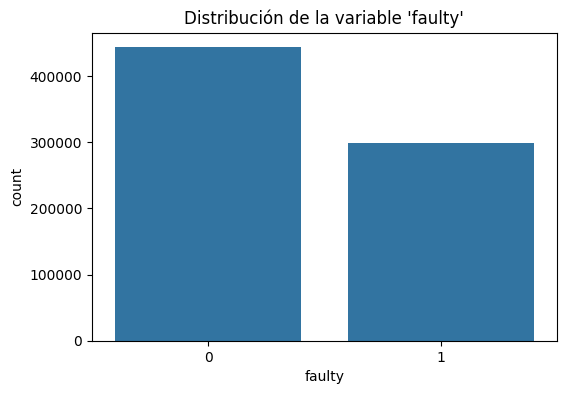

In [180]:
plt.figure(figsize=(6,4))
sns.countplot(x='faulty', data=df)
plt.title("Distribución de la variable 'faulty'")
plt.show()

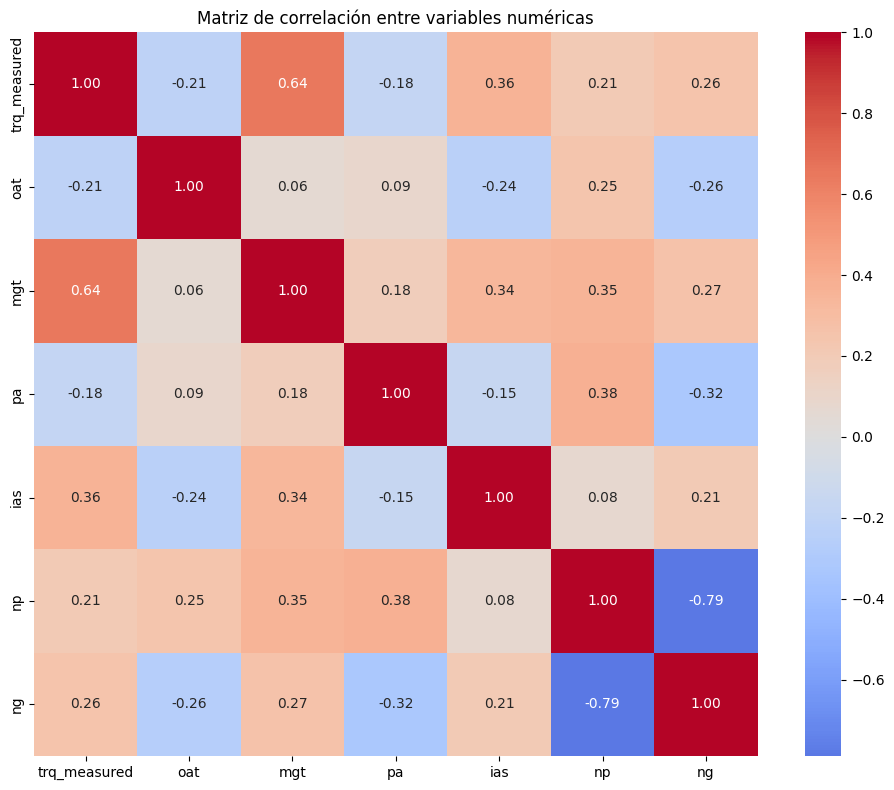

In [181]:
features_numeric = X_train.columns.drop('id')  # excluimos 'id' si aún está

corr_matrix = df[features_numeric].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True)
plt.title("Matriz de correlación entre variables numéricas")
plt.tight_layout()

plt.show()


#### Estadísticas y distribución de trq_margin

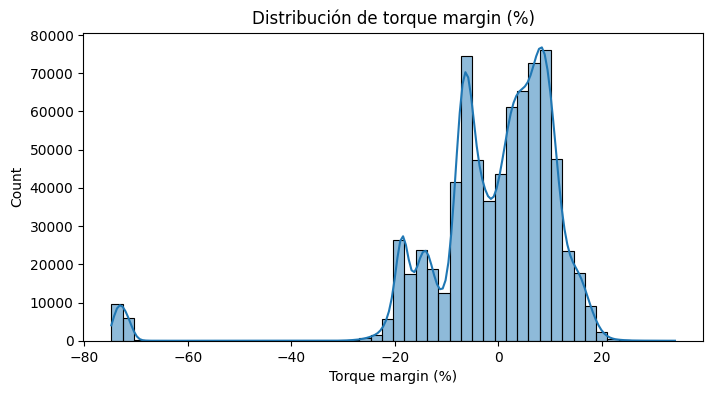

In [182]:
plt.figure(figsize=(8,4))
sns.histplot(df['trq_margin'], bins=50, kde=True)
plt.title("Distribución de torque margin (%)")
plt.xlabel("Torque margin (%)")
plt.show()

#### Ver distribución del trq_margin según clase (faulty)

/var/folders/vt/syg68fp95q15l87289j7tthm0000gq/T/ipykernel_68850/3934733673.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Faulty")


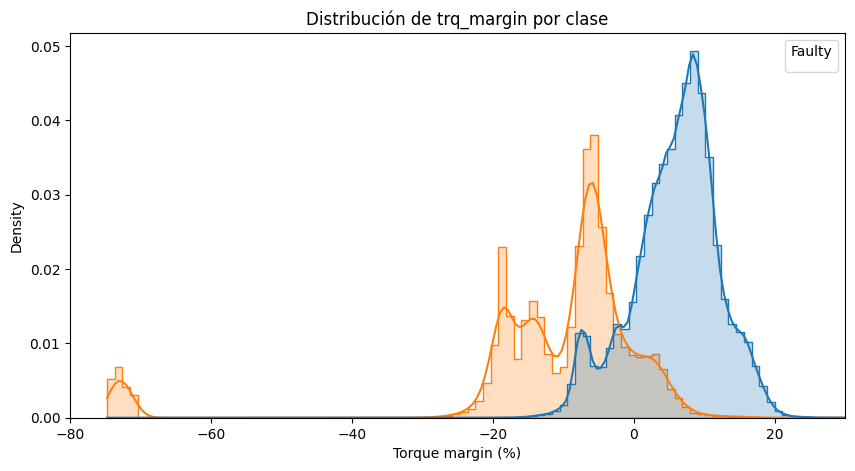

In [183]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='trq_margin', hue='faulty', bins=100, kde=True, element="step", stat='density')
plt.xlim(-80, 30)
plt.title("Distribución de trq_margin por clase")
plt.xlabel("Torque margin (%)")
plt.legend(title="Faulty")
plt.show()


In [184]:
thresholds = np.arange(-80, 10, 5)
results = []

for t in thresholds:
    subset = df[df['trq_margin'] < t]
    if len(subset) > 0:
        faulty_rate = subset['faulty'].mean()
        results.append((t, len(subset), faulty_rate))

threshold_df = pd.DataFrame(results, columns=['threshold', 'n_samples', 'faulty_rate'])
display(threshold_df)


,threshold,n_samples,faulty_rate
0,-70,15561,1.000000
1,-65,15617,1.000000
2,-60,15617,1.000000
3,-55,15617,1.000000
4,-50,15617,1.000000
5,-45,15617,1.000000
6,-40,15618,0.999936
7,-35,15625,0.999616
8,-30,15651,0.998914
9,-25,16332,0.997612


Todos los registros con trq_margin < -45% tienen una tasa de faulty = 1 de 100%
Incluso hasta trq_margin < -30%, más del 99.8% son fallos

 los valores extremadamente negativos de torque margin son una señal confiable de fallo

In [185]:
print("Descripción de torque margin:")
display(df['trq_margin'].describe())

Descripción de torque margin:


count    742625.000000
mean         -1.157346
std          14.068843
min         -74.747111
25%          -6.604321
50%           1.693847
75%           7.785348
max          34.148857
Name: trq_margin, dtype: float64

#### Boxplot para ver outliers en torque margin

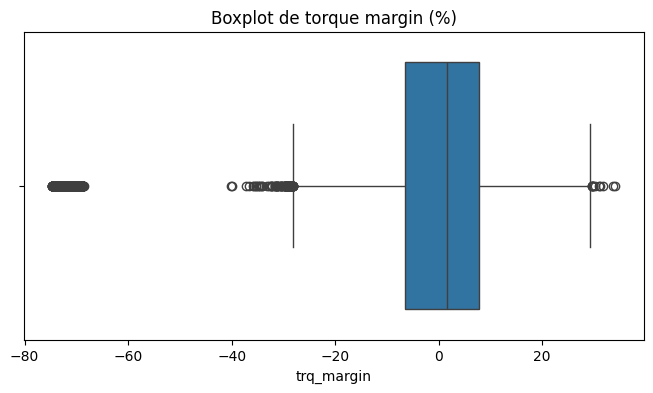

In [186]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df['trq_margin'])
plt.title("Boxplot de torque margin (%)")
plt.show()

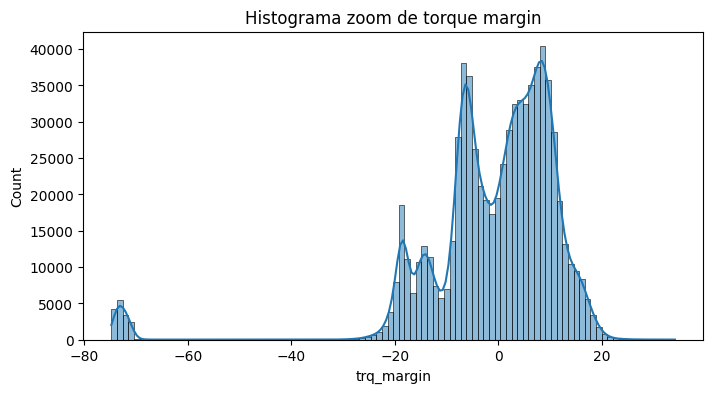

In [187]:
plt.figure(figsize=(8,4))
sns.histplot(df['trq_margin'], bins=100, kde=True)
plt.title("Histograma zoom de torque margin")
plt.show()

#### Zoom al histograma en rango -20 a 20 para ver distribución central mejor

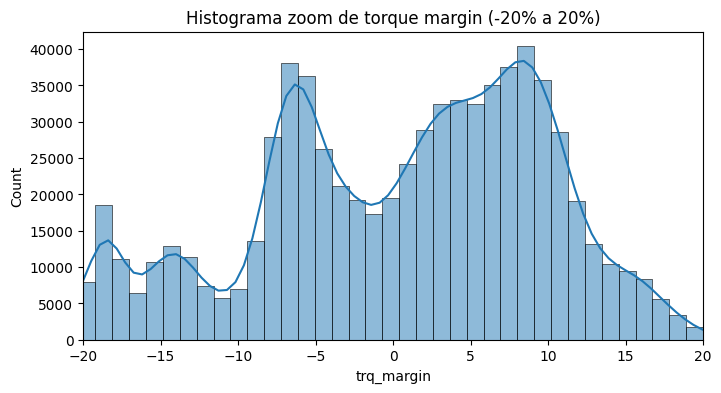

In [188]:
plt.figure(figsize=(8,4))
sns.histplot(df['trq_margin'], bins=100, kde=True)
plt.xlim(-20, 20)
plt.title("Histograma zoom de torque margin (-20% a 20%)")
plt.show()

####  Estadísticas para decidir tratamiento

##### Winsorizing: limitar valores extremos a percentiles 1 y 99
El Winsorizing evita que valores extremos exagerados afecten la regresión.

In [189]:
threshold_margin = -30
df_clean_reg = df[df['trq_margin'] >= threshold_margin].copy()

# Aplicar winsorizing (sobre datos ya filtrados)
q_low = df_clean_reg['trq_margin'].quantile(0.01)
q_high = df_clean_reg['trq_margin'].quantile(0.99)
df_clean_reg['trq_margin_wins'] = df_clean_reg['trq_margin'].clip(lower=q_low, upper=q_high)


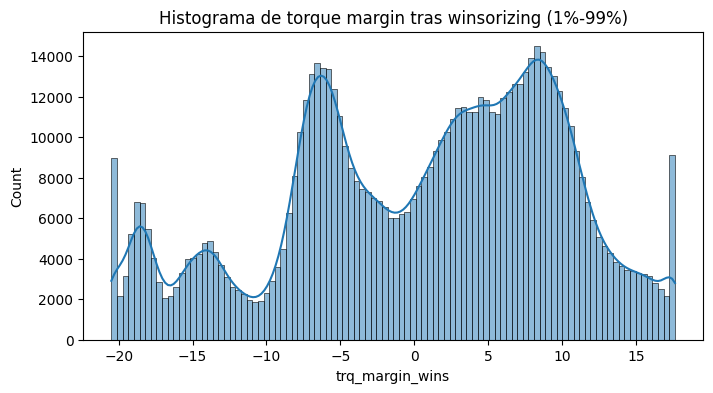

In [190]:
plt.figure(figsize=(8,4))
sns.histplot(df_clean_reg['trq_margin_wins'], bins=100, kde=True)
plt.title("Histograma de torque margin tras winsorizing (1%-99%)")
plt.show()

####  Agregar columna winsorizada al DataFrame limpio 

In [191]:
df_clean_cls.head(3)

,id,trq_measured,oat,mgt,pa,ias,np,ng,faulty,trq_margin
0,0,54.100,2.00000,544.5000,212.1408,74.56250,89.18000,99.6400,1,-13.717745
1,1,49.625,24.22231,578.4844,1625.6400,30.35596,99.55273,91.3866,0,1.791863
2,2,52.000,7.00000,566.1000,1912.9250,65.62500,100.14000,90.9600,1,-13.944871


#### Separar features para clasificación y regresión

In [192]:
X_reg = df_clean_reg.drop(columns=['faulty', 'trq_margin', 'trq_margin_wins'])
Y_reg = df_clean_reg[['id', 'trq_margin', 'trq_margin_wins']]

In [193]:
X_reg.head(3)

,id,trq_measured,oat,mgt,pa,ias,np,ng
0,0,54.100,2.00000,544.5000,212.1408,74.56250,89.18000,99.6400
1,1,49.625,24.22231,578.4844,1625.6400,30.35596,99.55273,91.3866
2,2,52.000,7.00000,566.1000,1912.9250,65.62500,100.14000,90.9600


In [194]:
Y_reg.head(3)

,id,trq_margin,trq_margin_wins
0,0,-13.717745,-13.717745
1,1,1.791863,1.791863
2,2,-13.944871,-13.944871


#### Dividir en train/val/test

In [195]:
test_size = 0.2
random_state = 42

# Clasificación: estratificada
X_train_cls, X_test_cls, Y_train_cls, Y_test_cls = train_test_split(
    X_cls, Y_cls, test_size=test_size, stratify=Y_cls['faulty'], random_state=random_state)

# Regresión: sin estratificar
X_train_reg, X_test_reg, Y_train_reg, Y_test_reg = train_test_split(
    X_reg, Y_reg, test_size=test_size, random_state=random_state)


In [196]:
X_train_cls.shape

(594100, 8)

#### Salvar los archivos

In [197]:
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)
# Guardar el scaler
joblib.dump(scaler_reg, "../data/processed/avance3/scaler_reg.joblib")

# 7. Guardar conjuntos procesados
os.makedirs("../data/processed/avance3", exist_ok=True)

# Clasificación
X_train_cls.to_csv("../data/processed/avance3/X_train_cls_new.csv", index=False)
Y_train_cls.to_csv("../data/processed/avance3/y_train_cls_new.csv", index=False)
X_test_cls.to_csv("../data/processed/avance3/X_test_cls_new.csv", index=False)
Y_test_cls.to_csv("../data/processed/avance3/y_test_cls_new.csv", index=False)

In [198]:
# Regresión (sin outliers)
pd.DataFrame(X_train_reg_scaled, columns=X_train_reg.columns).to_csv("../data/processed/avance3/X_train_reg_new.csv", index=False)
pd.DataFrame(X_test_reg_scaled, columns=X_test_reg.columns).to_csv("../data/processed/avance3/X_test_reg_new.csv", index=False)
Y_train_reg.to_csv("../data/processed/avance3/y_train_reg_new.csv", index=False)
Y_test_reg.to_csv("../data/processed/avance3/y_test_reg_new.csv", index=False)

In [199]:
X_train_cls.shape

(594100, 8)

In [200]:
joblib.dump(scaler_reg, "../data/processed/scaler_reg.joblib")

['../data/processed/scaler_reg.joblib']

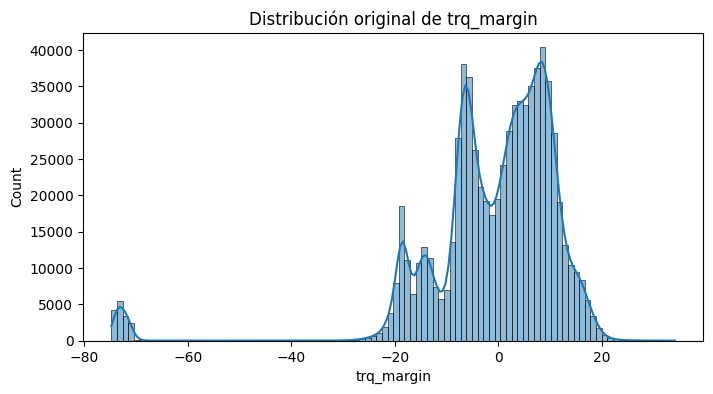

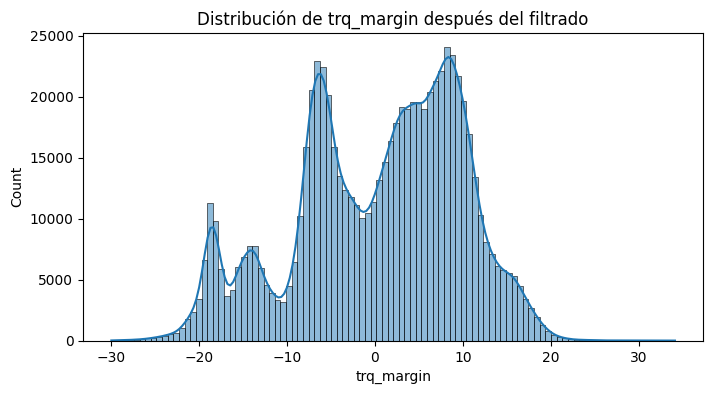

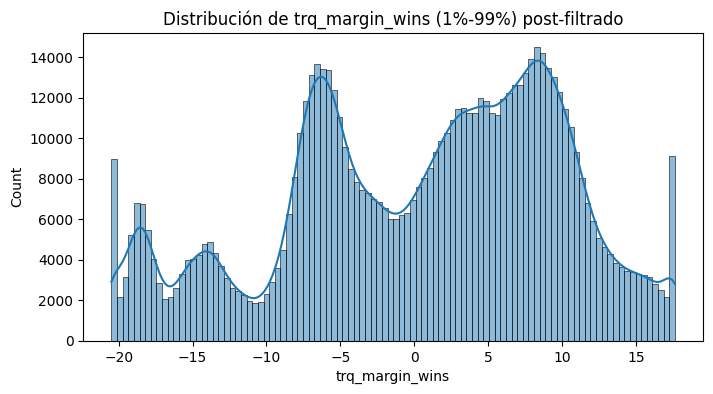

In [201]:
plt.figure(figsize=(8, 4))
sns.histplot(df['trq_margin'], bins=100, kde=True)
plt.title("Distribución original de trq_margin")
plt.savefig("./figures/trq_margin_original.png")
plt.show()

# Filtrado (>= -30%)
plt.figure(figsize=(8, 4))
sns.histplot(df_clean_reg['trq_margin'], bins=100, kde=True)
plt.title("Distribución de trq_margin después del filtrado")
plt.savefig("./figures/trq_margin_filtrado.png")
plt.show()

# Winsorizado
plt.figure(figsize=(8, 4))
sns.histplot(df_clean_reg['trq_margin_wins'], bins=100, kde=True)
plt.title("Distribución de trq_margin_wins (1%-99%) post-filtrado")
plt.savefig("./figures/trq_margin_winsorized.png")
plt.show()